In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, r2_score
from sklearn.metrics import mean_squared_error as mse

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import keras_tuner as kt

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from  IPython import display

import pathlib
import shutil
import tempfile

print(tf.__version__)

2.7.0


In [2]:
from numpy.random import seed
from numpy.random import RandomState

np.random.seed(42)
tf.random.set_seed(42)

In [3]:
def model_evaluation(y_pred, y_actual):
    """
    returns evaluation metrics for the model:
    Accuracy, F1 Score, R Squre, RMSe
    """
    acc = 0
    f1score = 0
    rmse = 0
    r_sqaure = 0
    
    if len(y_pred) != len(y_actual):
        print('predicted and actual length not equal')
        
    else:
        len_y = len(y_pred)
        
        y_pred_bool =  y_pred >= 0
        y_actual_bool =  y_actual >= 0
        f1score = f1_score(y_actual_bool, y_pred_bool, average='binary')
        acc = accuracy_score(y_actual_bool, y_pred_bool)
        
        rmse = np.sqrt(mse(y_actual, y_pred))
        r_sqaure = r2_score(y_actual, y_pred)
        
    df_evaluation = pd.DataFrame({'Accuracy': pd.Series(acc),
                                 'F1 Score': pd.Series(f1score),
                                 'R Square': pd.Series(r_sqaure),
                                 'RMSE': pd.Series(rmse)})
    return(df_evaluation)

In [5]:
data = pd.read_csv("./../data/nba_final_data.csv")
data = data.sample(frac=1, random_state = 42) # Shuffle data
y = data['PLUS_MINUS_HOME']
X = data.drop(['GAME_ID', "TEAM_ID_HOME", "TEAM_ID_AWAY", "GAME_DATE", "SEASON",
               "PLUS_MINUS_HOME", "MIN_HOME", 'WL_Home_modified'], axis=1)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [6]:
model = tf.keras.models.load_model('final_model')

In [22]:
model.evaluate(X_test, y_test)

104/104 [==============================] - 0s 926us/step - loss: 154.7836 - mse: 152.3198


[154.7836151123047, 152.31983947753906]

In [85]:
predictions = model.predict(X_test)
model_evaluation(predictions, y_test)

,Accuracy,F1 Score,R Square,RMSE
0,0.631199,0.718125,0.1166,12.341792


In [61]:
win_predictions = predictions[predictions > 0]
win_idx = np.where(predictions[predictions > 0])[0]
y_wins = y_test.reset_index().loc[win_idx, 'PLUS_MINUS_HOME']

loss_predictions = predictions[predictions < 0]
loss_idx = np.where(predictions[predictions < 0])[0]
y_losses = y_test.reset_index().loc[loss_idx, 'PLUS_MINUS_HOME']

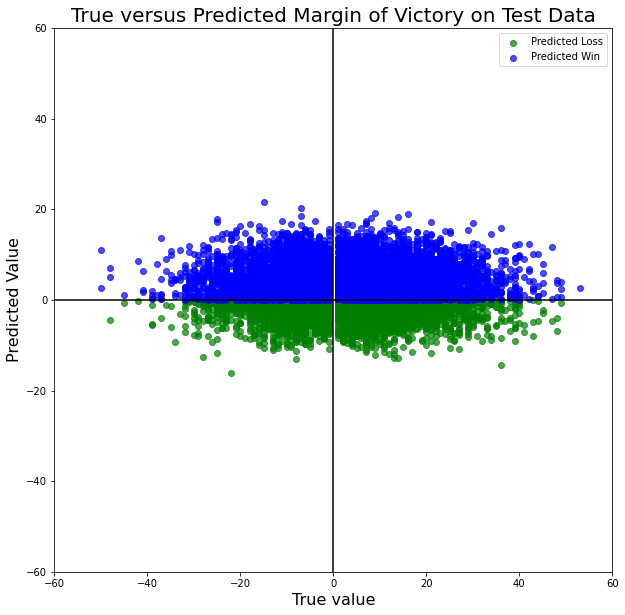

In [79]:

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(y_losses, loss_predictions, alpha =0.7, c='g', label="Predicted Loss")
ax.scatter(y_wins, win_predictions, alpha =0.7, c='b', label="Predicted Win")
ax.set_title("True versus Predicted Margin of Victory on Test Data", size=20)
ax.set_xlabel("True value", size=16)
ax.set_ylabel("Predicted Value", size=16)
ax.axhline(y=0, color='black', linestyle='-')
ax.axvline(x=0, color='black', linestyle='-')
ax.set_xlim([-60, 60])
ax.set_ylim([-60, 60])
ax.legend()

In [71]:
predictions = model.predict(X_train)
model_evaluation(predictions, y_train)

,Accuracy,F1 Score,R Square,RMSE
0,0.649985,0.736031,0.146152,12.342862


In [72]:
win_predictions = predictions[predictions > 0]
win_idx = np.where(predictions[predictions > 0])[0]
y_wins = y_train.reset_index().loc[win_idx, 'PLUS_MINUS_HOME']

loss_predictions = predictions[predictions < 0]
loss_idx = np.where(predictions[predictions < 0])[0]
y_losses = y_train.reset_index().loc[loss_idx, 'PLUS_MINUS_HOME']

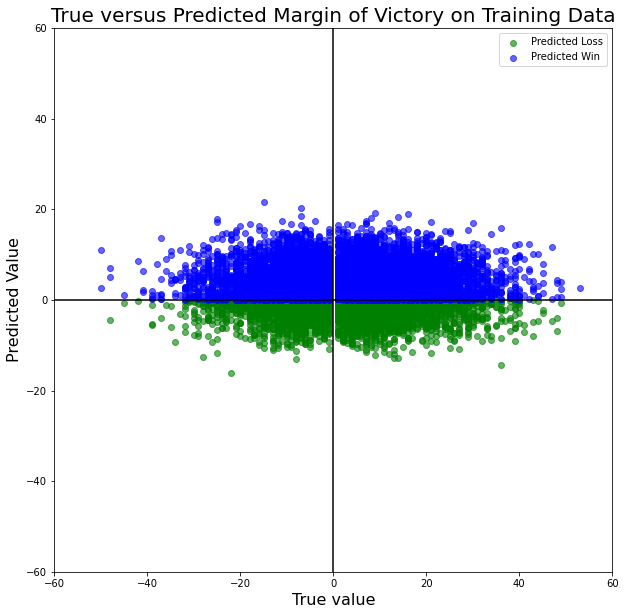

In [78]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(y_losses, loss_predictions, alpha =0.6, c='g', label="Predicted Loss")
ax.scatter(y_wins, win_predictions, alpha =0.6, c='b', label="Predicted Win")
ax.set_title("True versus Predicted Margin of Victory on Training Data", size=20)
ax.set_xlabel("True value", size =16)
ax.set_ylabel("Predicted Value", size= 16)
ax.axhline(y=0, color='black', linestyle='-')
ax.axvline(x=0, color='black', linestyle='-')
ax.set_xlim([-60, 60])
ax.set_ylim([-60, 60])
ax.legend()

In [89]:
print(np.mean(y_test -predictions[:, 0]))
print(np.std(predictions))
print(np.std(y_test))

0.31741921011126717
4.5410504
13.131056241273988
